In [1]:
import Pkg
Pkg.activate("BosonStars")
# Pkg.resolve()

using CairoMakie
using Printf
using Colors
using DelimitedFiles
using Revise
using Skylight
includet("ranges.jl")
includet("juliacolors.jl")

  Activating project at `/serafin/jpelle/BosonStars/BosonStars`


In [6]:
zmin, zmaxLBS = ranges(get_filenames("LBS"))
zmin, zmaxSBS = ranges(get_filenames("SBS"))
zmaxglobal = max(zmaxLBS, zmaxSBS)

4.570640437216029e22

In [8]:
filenames = get_filenames("SBS")
data = Matrix{Any}(undef, 3, 3)
zmaxcols = zeros(3)
num_bins = 50
for j in 1:3
    zmin, zmaxcol = ranges(filenames[:,j]) 
    zmaxcols[j] = zmaxcol
    for i in 1:3
        initial_data, output_data, configurations = load_everything(filenames[i,j])
        Iobs = observed_bolometric_intensities(initial_data, output_data, configurations)
        xs,ys = axes_ranges(configurations.camera)
        zs = grid_view(Iobs, configurations)
        data[i,j] = (xs, ys, zs)
    end
end

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/jpelle/.julia/packages/Makie/z2T2o/src/scenes.jl:220
┌ Warning: Could not find font Times New Roman, using TeX Gyre Heros Makie
└ @ Makie /home/jpelle/.julia/packages/Makie/z2T2o/src/conversions.jl:1138


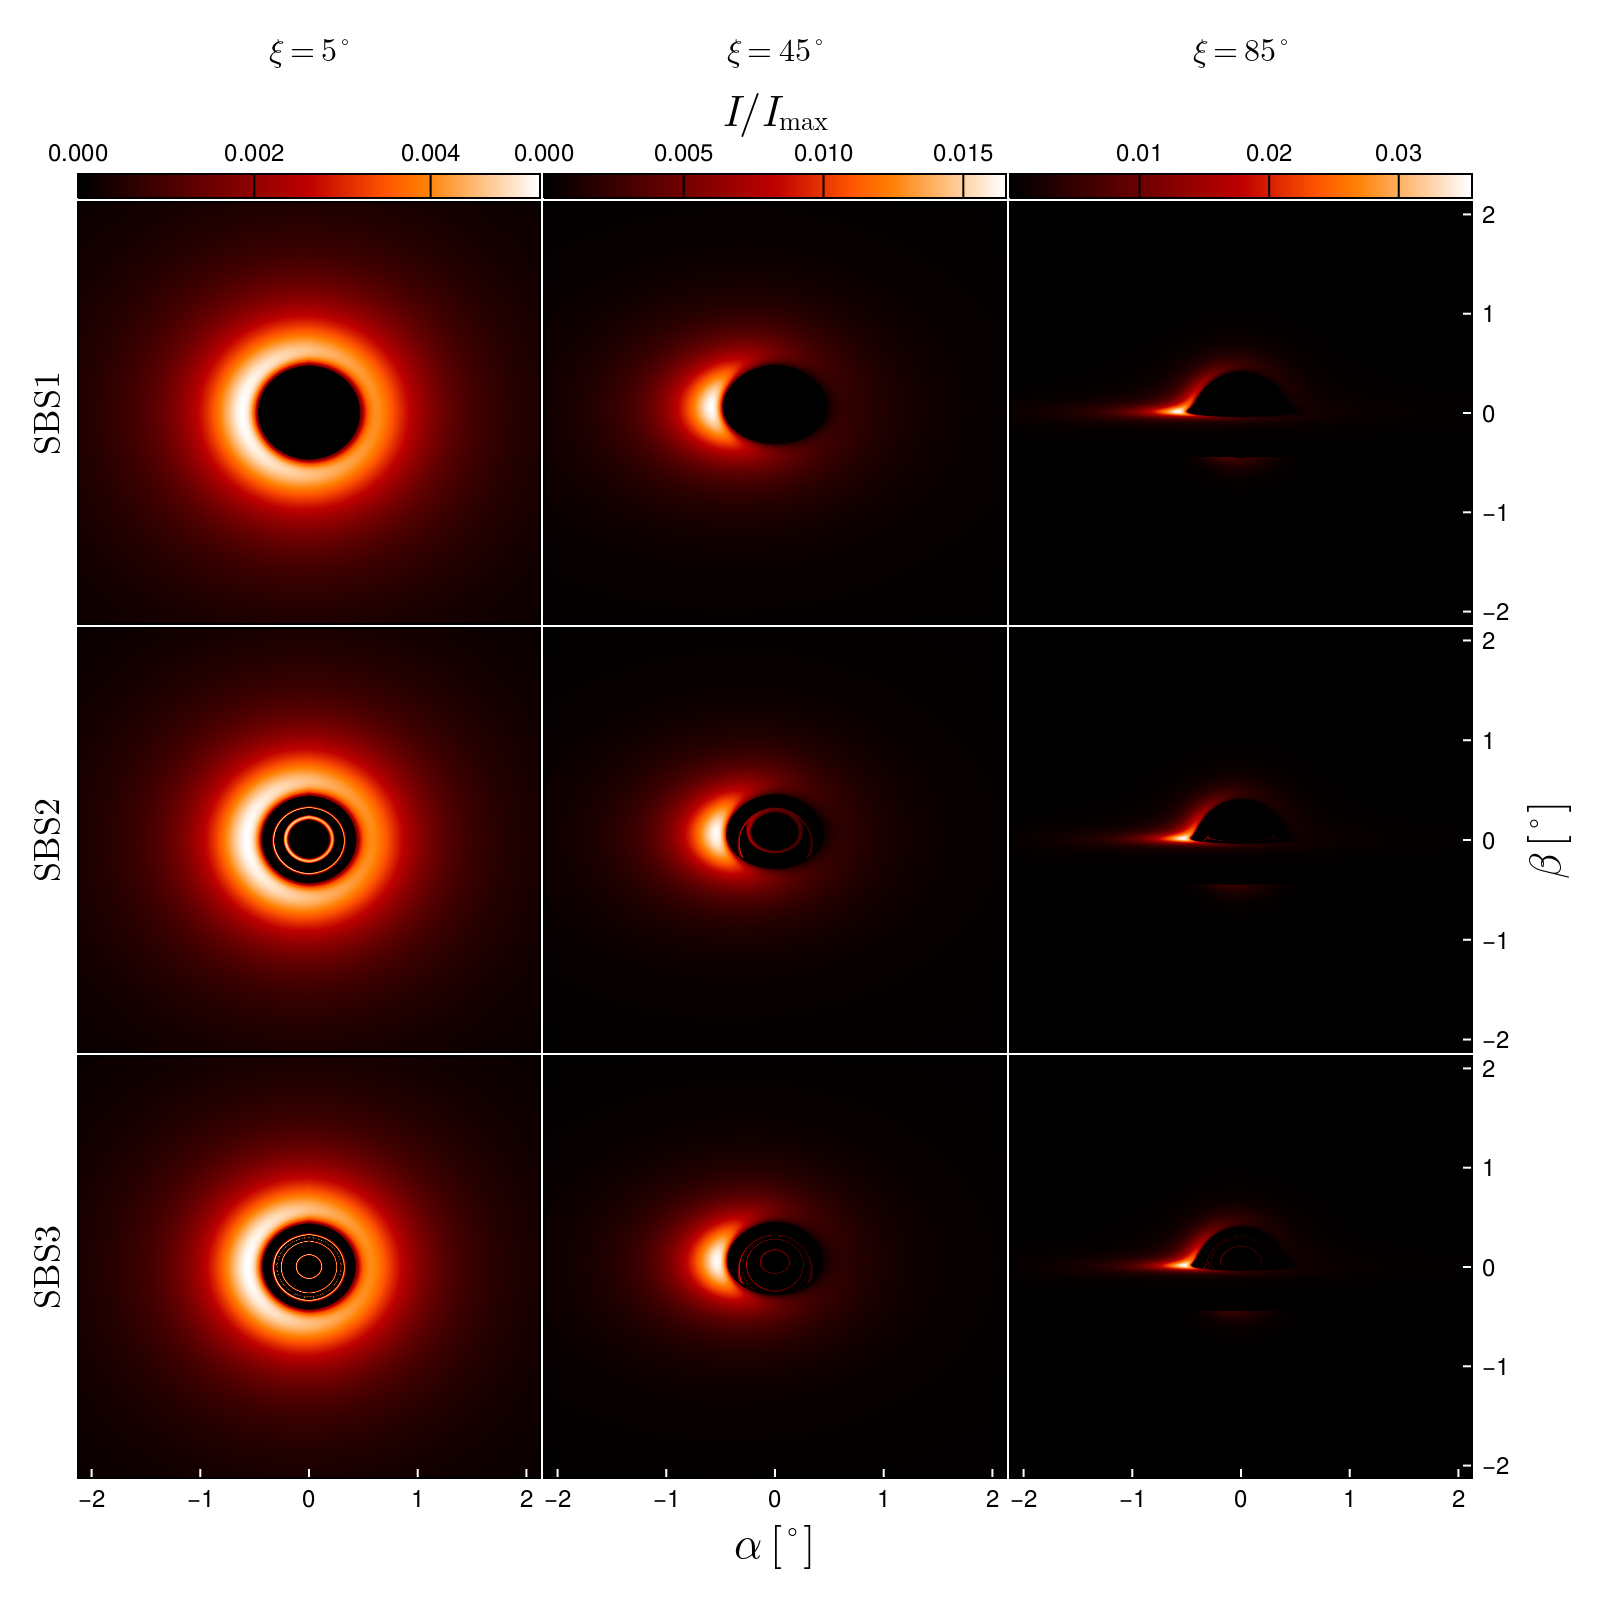

CairoMakie.Screen{PDF}


In [9]:
axes = Matrix{Axis}(undef, 3, 3)
set_theme!(; fonts = (; regular = "Times New Roman"))
layout = GridLayout(3, 3)
fig = Figure(layout = layout, size = (800, 800))
inclination_labels = [L"\xi = 5^\circ", L"\xi = 45^\circ", L"\xi = 85^\circ"]
# inclination_labels = [L"5^\circ", L"45^\circ", L"85^\circ"]
cbar_ticks_LBS = [[0.0,0.02,0.05],[0.0, 0.1, 0.2],[0.0, 0.5, 1.0]]
cbar_ticks_SBS = [[0.0,0.002,0.004],[0.0, 0.005, 0.01, 0.015],[0.01, 0.02, 0.03]]
for j in 1:3
    for i in 1:3
        ax = Axis(fig[i,j])
        axes[i,j] = ax
        xs, ys, zs = data[i,j]
        xs = rad2deg.(xs)
        ys = rad2deg.(ys)
        hmap = heatmap!(xs, ys, zs/zmaxcols[j]; colormap=:gist_heat, interpolate=true)
    end
end

for k in 1:3

    axbottom = axes[3,k]
    axtop = axes[1,k]
    axright = axes[k,3]
    axleft = axes[k,1]
    # axbottom.xlabel = L"\alpha \, [\text{rad}]"
    axbottom.xlabel = L"\alpha \, [^\circ]"
    axbottom.xlabelvisible = k == 2 #Only show xlabel for middle column
    axbottom.xlabelsize = 22
    axbottom.xticklabelsize = 12
    axbottom.xtickalign = 1
    axbottom.xtickcolor = :white

    axright.yaxisposition = :right
    axright.ylabelvisible = k == 2 #Only show ylabel for middle row
    # axright.ylabel = L"\beta \, [\text{rad}]"
    axright.ylabel = L"\beta \, [^\circ]"
    axright.ylabelsize = 22
    axright.yticklabelsize = 12
    axright.ytickalign = 1
    axright.ytickcolor = :white

    for l in 1:2
    
        #Link axes and hide decorations of non-right and non-bottom axes
        #axis linking is redundant here (the ranges coincide already), but just in case
        linkxaxes!(axright, axes[l,k])
        hidexdecorations!(axes[l,k])
        linkyaxes!(axleft, axes[k,l])
        hideydecorations!(axes[k,l])
    end

    #Make left ylabel visible again to use as model label
    axleft.ylabelvisible = true
    # axleft.ylabel = L"\Lambda \text{BS%$(k)}"
    axleft.ylabel = L"\text{SBS%$(k)}"
    axleft.ylabelsize = 18
    
    
    cbar = Colorbar(fig[0,k], vertical=false, colormap=:gist_heat, colorrange = (0,zmaxcols[k]/zmaxglobal), label=inclination_labels[k])
    cbar.size = 12 
    cbar.ticks = cbar_ticks_SBS[k]
    cbar.tickalign = 1
    cbar.ticksize = 12
    cbar.ticklabelsize = 12
    cbar.tickcolor = :black
    cbar.label = L"I/I_{\text{max}}"
    cbar.labelsize = 22
    cbar.labelpadding = 0.5
    cbar.labelvisible = k == 2 #Only show colorbar label for middle column
    
    supertitle = Label(fig[-1,k], inclination_labels[k], justification=:center, fontsize=16, color=:black)
    supertitle.tellwidth = false
    supertitle.padding = (0.0, 0.0, 10.0, 0.0)

end

colgap!(fig.layout, 2)
rowgap!(fig.layout, 2)
display(fig)
save("plots/SBSmosaic_new.pdf", fig, pt_per_unit = 0.5)
# save("plots/LBSmosaic.pdf", fig, pt_per_unit = 0.5)

Spectrum

In [34]:
function get_sch_filenames()
    filenames = Vector{String}(undef, 3)
    inclinations = [5, 45, 85]
    Nres = 1200
    for i in 1:3
        modelname = "SCHW"
        ξ = inclinations[i]
        ξstr = string(@sprintf("%02d", ξ))
        Nstr = string(@sprintf("%03d", Nres))
        filenames[i] = "$(modelname)_i$(ξstr)deg_N$(Nstr)"
        @assert isfile("io/$(filenames[i]).h5") "File $(filenames[i]).h5 does not exist"
    end
    return filenames
end

get_sch_filenames (generic function with 1 method)

In [13]:
function get_data(model, obs_energies)
    filenames = get_filenames(model)
    data = Matrix{Any}(undef, 3, 3)

    for j in 1:3
        for i in 1:3
            initial_data, output_data, configurations = load_everything(filenames[i,j])
            F = spectrum(initial_data, output_data, configurations, obs_energies)
            data[i,j] = F
        end
    end
    return data
end
function get_data_schw(obs_energies)
    filenames = get_sch_filenames()
    data = Vector{Any}(undef, 3)

    for j in 1:3
        initial_data, output_data, configurations = load_everything(filenames[j])
        F = spectrum(initial_data, output_data, configurations, obs_energies)
        data[j] = F
    end
    return data
end

get_data_schw (generic function with 1 method)

In [14]:
ε = eV_to_erg(1.0)
obs_energies = ε*exp10.(range(0.0, stop=4.0, length=20))

data_LBS = get_data("LBS", obs_energies)
data_SBS = get_data("SBS", obs_energies)
data_SCH = get_data_schw(obs_energies)

3-element Vector{Any}:
 [1.650900270191604e22, 4.33732495356324e22, 1.1369772788429914e23, 2.9696049225117963e23, 7.710099884245199e23, 1.982361635228604e24, 5.015548018195458e24, 1.2354765972097877e25, 2.9092562664767343e25, 6.341746266660901e25, 1.2082078692952206e26, 1.8153965891197517e26, 1.8082065881362813e26, 9.173992967224593e25, 1.622082033015748e25, 5.430924210482959e23, 1.2112311342773903e21, 3.2447142533442224e16, 6.700020832661858e8, 0.00012764950637170845]
 [1.545756032933967e22, 4.060089637414069e22, 1.0638791123810571e23, 2.7768804992287818e23, 7.202091392690833e23, 1.8485437885525416e24, 4.6637219022110076e24, 1.1434615429022772e25, 2.6719919664479418e25, 5.7524731427896496e25, 1.0753279887245474e26, 1.5790929526498838e26, 1.5664621513300012e26, 8.675367163512618e25, 2.1076158805443388e25, 1.4843499146655818e24, 1.385622228923878e22, 4.495244755048038e18, 5.848385773919429e12, 939.7307743319069]
 [4.255104675873104e21, 1.1172290516163626e22, 2.9257307392585524e22, 7.629

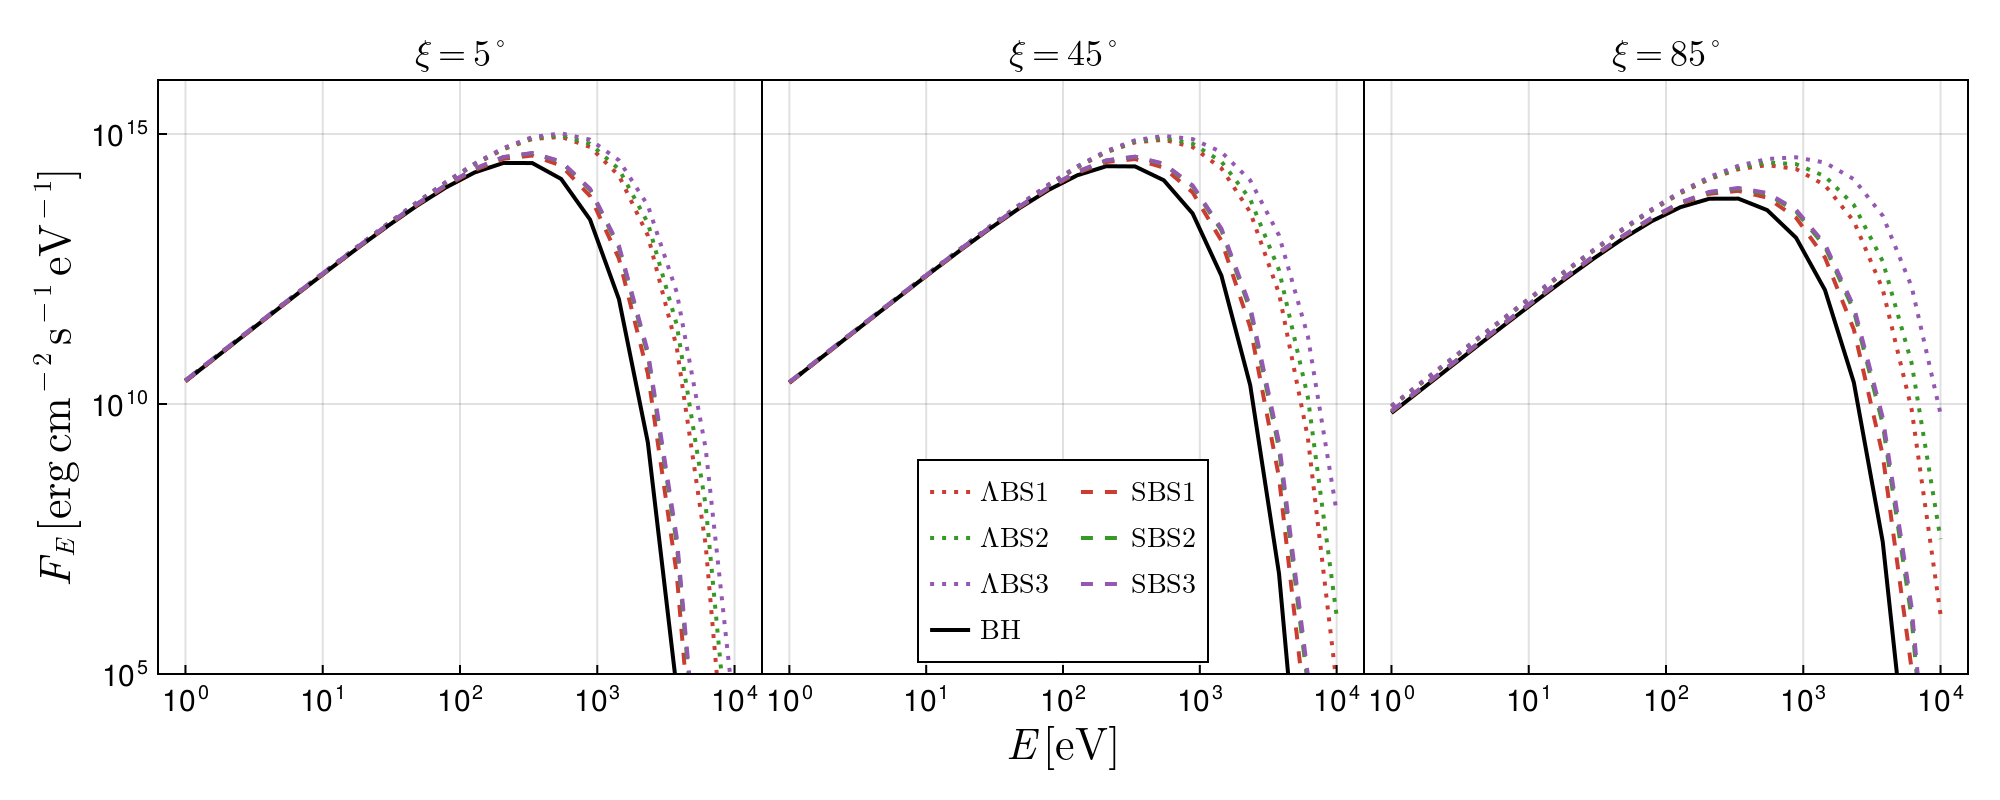

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/jpelle/.julia/packages/Makie/z2T2o/src/scenes.jl:220


CairoMakie.Screen{PDF}


In [17]:
axes = Matrix{Axis}(undef, 1,3)
set_theme!(; fonts = (; regular = "Times New Roman"))
layout = GridLayout(1,3)
fig = Figure(layout = layout, size
inclination_labels = [L"\xi = 5^\circ", L"\xi = 45^\circ", L"\xi = 85^\circ"]
model_labelsL = [L"\Lambda \text{BS%$(k)}" for k in 1:3]
model_labelsS = [L"\text{SBS%$(k)}" for k in 1:3]
colors = [julia_red, julia_green, julia_purple]

for j in 1:3
    axes[j] = Axis(fig[1,j])
end

axleft = axes[1,1]
axmid = axes[1,2]
axright = axes[1,3]

#Link axes and hide decorations of non-right and non-bottom axes
#axis linking is redundant here (the ranges coincide already), but just in case
linkyaxes!(axleft, axmid)
linkyaxes!(axleft, axright)
hideydecorations!(axmid, grid=false)
hideydecorations!(axright, grid=false)

#Only show xlabel for middle column
axleft.xlabelvisible = false 
axright.xlabelvisible = false 

axleft.ylabel = L"F_E \,[\text{erg} \, \text{cm}^{-2} \, \text{s}^{-1}\,\text{eV}^{-1}]"
axleft.ylabelsize = 22
axleft.yticklabelsize = 12
axleft.ytickalign = 1

for j in 1:3
    ax = axes[1,j]
    for i in [1,2,3]
        FL = data_LBS[i,j]
        labelL = L"%$(model_labelsL[i])"#, %$(inclination_labels[j])"
        lines!(ax, erg_to_eV(obs_energies), eV_to_erg(FL); linewidth=2.0, color=colors[i], linestyle=:dot, label=labelL)
    end
    FSCH = data_SCH[j]
    lines!(ax, erg_to_eV(obs_energies), eV_to_erg(FSCH); linewidth=2.0, color=:black, linestyle=:solid, label=L"\text{BH}")
    ylims!(ax, 1e5, 1e16)
    ax.xscale = log10
    ax.yscale = log10
    ax.title = inclination_labels[j]
    ax.titlesize = 18
    ax.xlabel = L"E \, [\text{eV}]"
    ax.xlabelsize = 22
    ax.ylabelsize = 22
    ax.xticklabelsize = 15
    ax.yticklabelsize = 15
    ax.xtickalign = 1
    # supertitle = Label(fig[0,j], inclination_labels[j], justification=:center, fontsize=16, color=:black)
    # supertitle.tellwidth = false
    # supertitle.padding = (0.0, 0.0, 10.0, 0.0)
    for i in [1,2,3]
        FS = data_SBS[i,j]
        labelS = L"%$(model_labelsS[i])"#, %$(inclination_labels[j])"
        lines!(ax, erg_to_eV(obs_energies), eV_to_erg(FS); linewidth=2.0, color=colors[i], linestyle=:dash, label=labelS)
    end
    # if j == 2
    # end
end

leg = axislegend(axmid, position=:cb, nbanks = 4, orientation=:horizontal)
# leg = Legend(fig[1,2], axmid, L"\text{Model}", nbanks = 4, tellwidth=false, tellheight=false, orientation=:horizontal, valign=:bottom)
colgap!(fig.layout, 0)
# colgap!(fig.layout, 3, 12)
display(fig)
save("plots/spectra_new.pdf", fig)

### Schwarzschild

In [260]:
filenames = get_filenames_schw()
data = Vector{Any}(undef, 3)
zmaxcols = zeros(3)
num_bins = 3
for i in 1:3
    qmin, qmax, zmin, zmaxcol, Fmax = ranges(filenames[i], num_bins) 
    zmaxcols[i] = zmaxcol
    initial_data, output_data, configurations = load_everything(filenames[i])
    Iobs, q = observed_bolometric_intensities(initial_data, output_data, configurations)
    xs,ys = axes_ranges(configurations.camera)
    zs = grid_view(Iobs, configurations)
    data[i] = (xs, ys, zs)
end

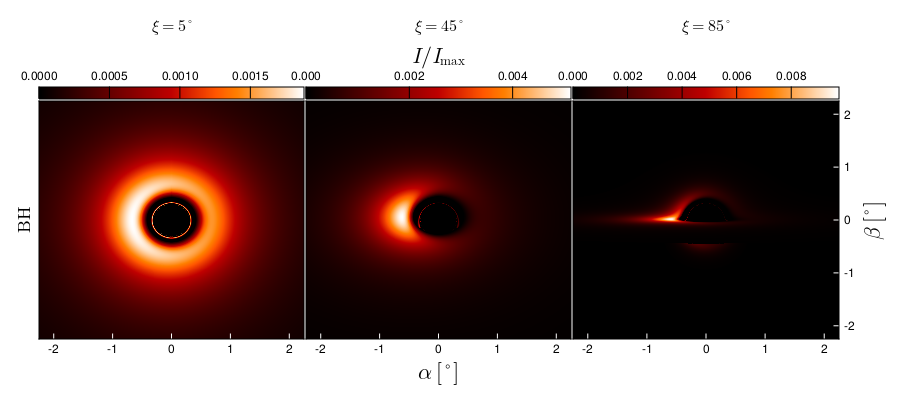

CairoMakie.Screen{PDF}


In [262]:
axes = Matrix{Axis}(undef, 1,3)
set_theme!(; fonts = (; regular = "Times New Roman"))
layout = GridLayout(1,3)
fig = Figure(layout = layout, size
inclination_labels = [L"\xi = 5^\circ", L"\xi = 45^\circ", L"\xi = 85^\circ"]
# inclination_labels = [L"5^\circ", L"45^\circ", L"85^\circ"]
cbar_ticks_SCHW = [[0.0,0.002,0.004],[0.0, 0.005, 0.01, 0.015],[0.01, 0.02, 0.03]]

for i in 1:3
    ax = Axis(fig[1,i])
    axes[i] = ax
    xs, ys, zs = data[i]
    xs = rad2deg.(xs)
    ys = rad2deg.(ys)
    hmap = heatmap!(xs, ys, zs/zmaxcols[i]; colormap=:gist_heat, interpolate=true)
end

axleft = axes[1,1]
axmid = axes[1,2]
axright = axes[1,3]

#Link axes and hide decorations of non-right and non-bottom axes
#axis linking is redundant here (the ranges coincide already), but just in case
linkyaxes!(axleft, axmid)
linkyaxes!(axleft, axright)
hideydecorations!(axmid)
hideydecorations!(axleft)

#Only show xlabel for middle column
axleft.xlabelvisible = false 
axright.xlabelvisible = false 

axright.yaxisposition = :right
axright.ylabel = L"\beta \, [^\circ]"
axright.ylabelsize = 22
axright.yticklabelsize = 12
axright.ytickalign = 1
axright.ytickcolor = :white

#Make left ylabel visible again to use as model label
axleft.ylabelvisible = true
axleft.ylabel = L"\text{BH}"
axleft.ylabelsize = 18

for k in 1:3
    ax = axes[1,k]
    ax.xlabel = L"\alpha \, [^\circ]"
    ax.xlabelsize = 22
    ax.xticklabelsize = 12
    ax.xtickalign = 1
    ax.xtickcolor = :white

    cbar = Colorbar(fig[0,k], vertical=false, colormap=:gist_heat, colorrange = (0,zmaxcols[k]/zmaxglobal))
    cbar.size = 12 
    # cbar.ticks = cbar_ticks_SCHW[k]
    cbar.tickalign = 1
    cbar.ticksize = 12
    cbar.ticklabelsize = 12
    cbar.tickcolor = :black
    cbar.label = L"I/I_{\text{max}}"
    cbar.labelsize = 22
    cbar.labelpadding = 0.5
    cbar.labelvisible = k == 2 #Only show colorbar label for middle column

    supertitle = Label(fig[-1,k], inclination_labels[k], justification=:center, fontsize=16, color=:black)
    supertitle.tellwidth = false
    supertitle.padding = (0.0, 0.0, 10.0, 0.0)

    # colsize!(fig.layout, k, Aspect(1, 1.0))
end

colgap!(fig.layout, 2)
rowgap!(fig.layout, 2)
display(fig)
save("plots/SCHWmosaic.pdf", fig, pt_per_unit = 0.5)

# Line emission

### Profiles

In [49]:
function get_profile_data(model, heights; num_bins = 40)
    profile_filenames = get_profile_filenames(model, heights)
    data = Matrix{Any}(undef, 3, length(heights))
    for j in 1:3
        for i in 1:length(heights)
            filename="io/corona/bosonstar/$(profile_filenames[i,j]).txt"
            delim = '\t'
            data[i,j] = readdlm(filename, delim, Float64, '\n')
        end
    end
    return data
end

function get_sch_profile_data(heights; num_bins = 40)
    profile_filenames = get_sch_profile_filenames(heights)
    data = Vector{Any}(undef, length(heights))
    for i in 1:length(heights)
        filename="io/corona/schwarzschild/$(profile_filenames[i]).txt"
        delim = '\t'
        data[i] = readdlm(filename, delim, Float64, '\n')
    end
    return data
end

get_sch_profile_data (generic function with 1 method)

In [50]:
function flat_lamppost(r, h)
    return h/(r^2+h^2)^(3/2)
end

flat_lamppost (generic function with 1 method)

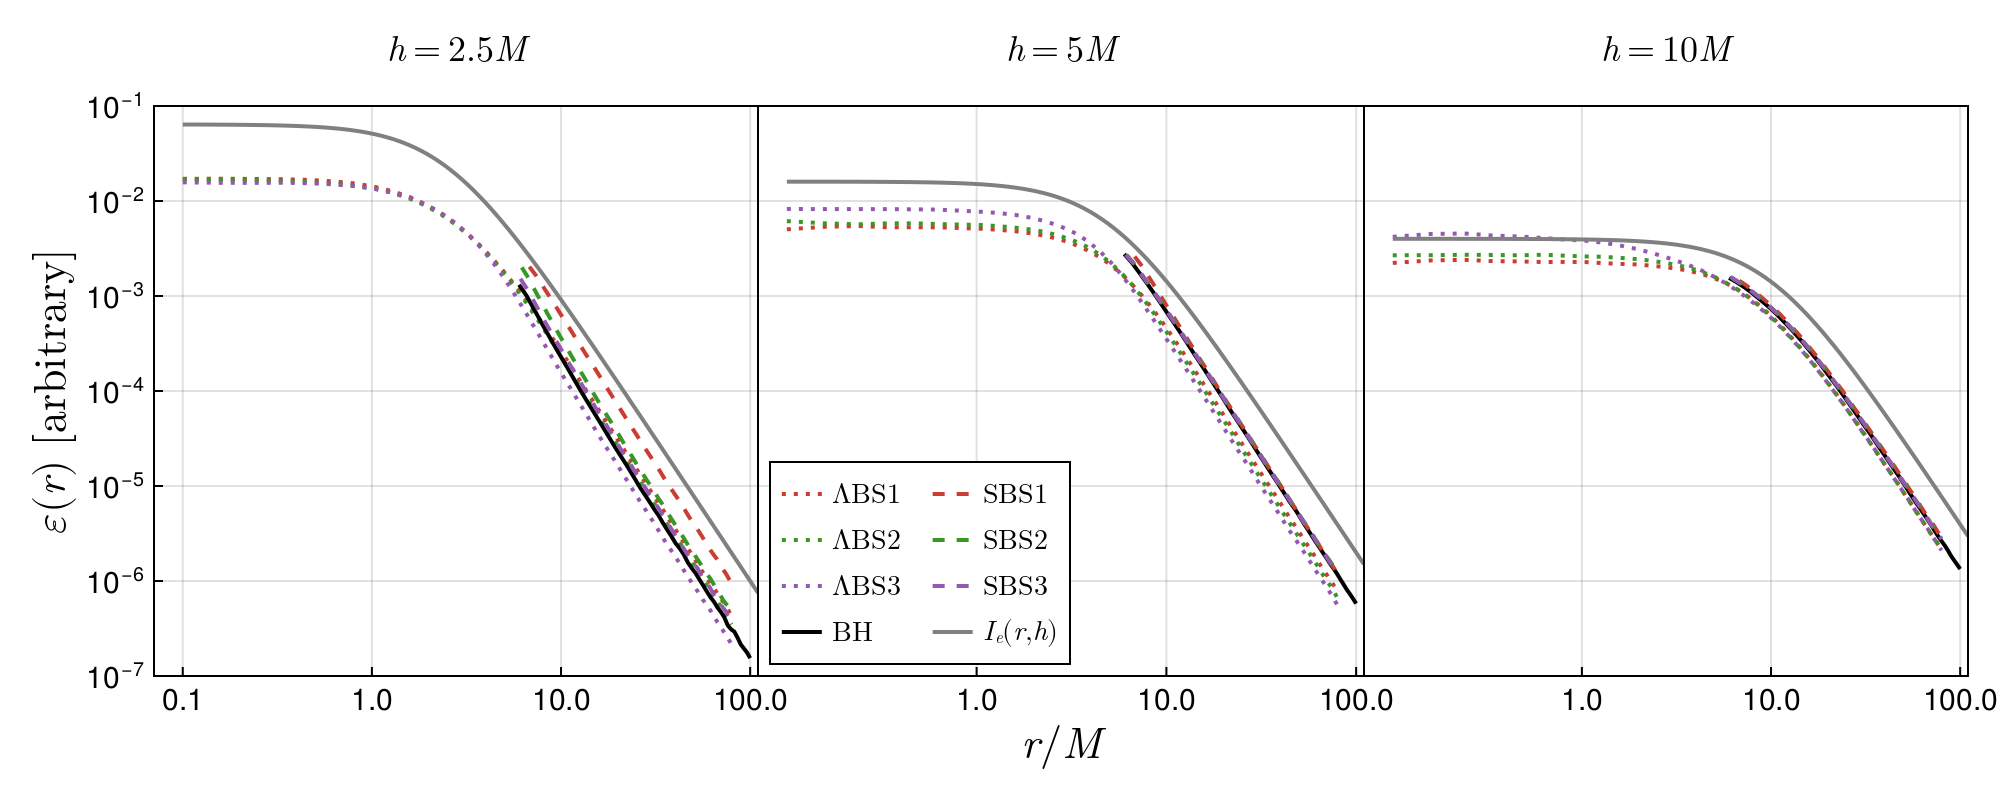

CairoMakie.Screen{PDF}


In [53]:
model = "LBS"
heights = Any[2.5, 5.0, 10.0]
data_LBS = get_profile_data("LBS", heights; num_bins = 40)
data_SBS = get_profile_data("SBS", heights; num_bins = 40)
data_SCH = get_sch_profile_data(heights; num_bins = 40)

axes = Matrix{Axis}(undef, 1,3)
set_theme!(; fonts = (; regular = "Times New Roman"))
layout = GridLayout(1,3)
fig = Figure(layout = layout, size=(1000,400))
height_labels = [L"h = 2.5 M", L"h = 5 M", L"h = 10 M"]
heights = [2.5, 5, 10]
model_labelsL = [L"\Lambda \text{BS1}", L"\Lambda \text{BS2}", L"\Lambda \text{BS3}"]
model_labelsS = [L"\text{SBS1}", L"\text{SBS2}", L"\text{SBS3}"]
colors = [julia_red, julia_green, julia_purple]
xticks= [[0.1,1.0,10.0,100.0],[1.0,10.0,100.0],[1.0,10.0,100.0]]

PL_factors = [2.0, 2.0, 2.0]

for j in 1:3
    axes[j] = Axis(fig[1,j])
end

axleft = axes[1,1]
axmid = axes[1,2]
axright = axes[1,3]

#Link axes and hide decorations of non-right and non-bottom axes
#axis linking is redundant here (the ranges coincide already), but just in case
linkyaxes!(axleft, axmid)
linkyaxes!(axleft, axright)
hideydecorations!(axmid, grid=false)
hideydecorations!(axright, grid=false)

#Only show xlabel for middle column
axleft.xlabelvisible = false 
axright.xlabelvisible = false 

axleft.ylabel = L"\varepsilon (r) \, \, [\text{arbitrary}]"
axleft.ylabelsize = 22
axleft.yticklabelsize = 12
axleft.ytickalign = 1

for j in 1:3
    ax = axes[1,j]
    for i in [1,2,3]
        dataL = data_LBS[i,j]
        labelL = L"%$(model_labelsL[i])"#, %$(inclination_labels[j])"
        lines!(ax, dataL[:,1], dataL[:,2]; linewidth=2.0, color=colors[i], linestyle=:dot, label=labelL)
    end
    dataSC = data_SCH[j]
    lines!(ax, dataSC[:,1], dataSC[:,2]; linewidth=2.0, color=:black, linestyle=:solid, label=L"\text{BH}")
    ylims!(ax, 1e-7, 1e-1)
    xlims!(ax, nothing,110.0)
    ax.xscale = log10
    ax.yscale = log10
    # ax.title = height_labels[j]
    ax.titlesize = 18
    ax.xlabel = L"r / M"
    ax.xlabelsize = 22
    ax.ylabelsize = 22
    ax.xticklabelsize = 15
    ax.yticklabelsize = 15
    ax.xtickalign = 1
    ax.xticks = xticks[j]
    ax.xtickformat = "{:.1f}"
    # supertitle = Label(fig[0,j], inclination_labels[j], justification=:center, fontsize=16, color=:black)
    # supertitle.tellwidth = false
    # supertitle.padding = (0.0, 0.0, 10.0, 0.0)
    for i in [1,2,3]
        dataS = data_SBS[i,j]
        labelS = L"%$(model_labelsS[i])"#, %$(inclination_labels[j])"
        lines!(ax, dataS[:,1], dataS[:,2]; linewidth=2.0, color=colors[i], linestyle=:dash, label=labelS)
    end
    rad = exp10.(range(log10(0.1), stop=log10(110), length=100))
    lamp = map(r -> flat_lamppost(r, heights[j]), rad)
    lines!(ax, rad, 0.4lamp; linewidth=2.0, color=:gray, linestyle=:solid, label=L"I_e(r,h)")
    # if j == 2
    # end
    supertitle = Label(fig[0,j], height_labels[j], justification=:center, fontsize=18, color=:black)
    supertitle.tellwidth = false
    supertitle.padding = (0.0, 0.0, 1.0, 0.0)
end

leg = axislegend(axmid, position=:lb, nbanks = 4, orientation=:horizontal)
# leg = Legend(fig[1,2], axmid, L"\text{Model}", nbanks = 4, tellwidth=false, tellheight=false, orientation=:horizontal, valign=:bottom)
colgap!(fig.layout, 0)
# colgap!(fig.layout, 3, 12)
display(fig)
save("plots/profiles_new.pdf", fig)

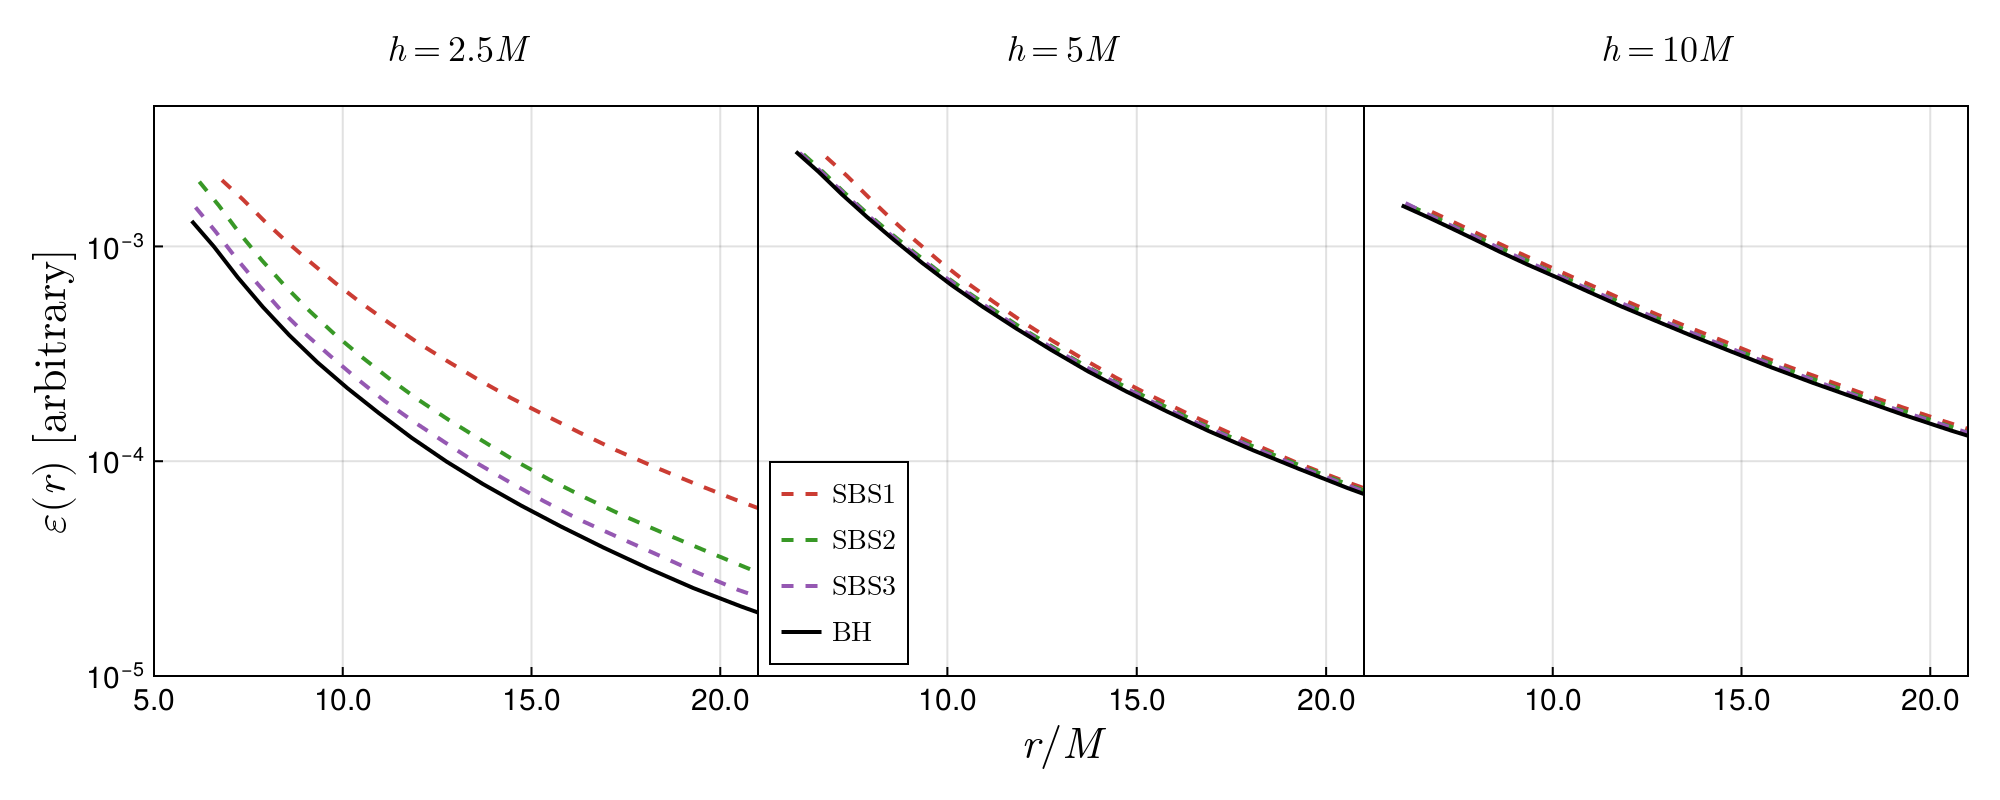

CairoMakie.Screen{PDF}


In [54]:
model = "LBS"
heights = Any[2.5, 5.0, 10.0]
data_LBS = get_profile_data("LBS", heights; num_bins = 40)
data_SBS = get_profile_data("SBS", heights; num_bins = 40)
data_SCH = get_sch_profile_data(heights; num_bins = 40)

axes = Matrix{Axis}(undef, 1,3)
set_theme!(; fonts = (; regular = "Times New Roman"))
layout = GridLayout(1,3)
fig = Figure(layout = layout, size=(1000,400))
height_labels = [L"h = 2.5 M", L"h = 5 M", L"h = 10 M"]
heights = [2.5, 5, 10]
model_labelsL = [L"\Lambda \text{BS1}", L"\Lambda \text{BS2}", L"\Lambda \text{BS3}"]
model_labelsS = [L"\text{SBS1}", L"\text{SBS2}", L"\text{SBS3}"]
colors = [julia_red, julia_green, julia_purple]
xticks= [[5.0,10.0,15.0,20.0],[10.0,15.0,20.0],[10.0,15.0,20.0]]

PL_factors = [2.0, 2.0, 2.0]

for j in 1:3
    axes[j] = Axis(fig[1,j])
end

axleft = axes[1,1]
axmid = axes[1,2]
axright = axes[1,3]

#Link axes and hide decorations of non-right and non-bottom axes
#axis linking is redundant here (the ranges coincide already), but just in case
linkyaxes!(axleft, axmid)
linkyaxes!(axleft, axright)
hideydecorations!(axmid, grid=false)
hideydecorations!(axright, grid=false)

#Only show xlabel for middle column
axleft.xlabelvisible = false 
axright.xlabelvisible = false 

axleft.ylabel = L"\varepsilon (r) \, \, [\text{arbitrary}]"
axleft.ylabelsize = 22
axleft.yticklabelsize = 12
axleft.ytickalign = 1

for j in 1:3
    ax = axes[1,j]
    # for i in [1,2,3]
    #     dataL = data_LBS[i,j]
    #     labelL = L"%$(model_labelsL[i])"#, %$(inclination_labels[j])"
    #     lines!(ax, dataL[:,1], dataL[:,2]; linewidth=2.0, color=colors[i], linestyle=:dot, label=labelL)
    # end
    for i in [1,2,3]
        dataS = data_SBS[i,j]
        labelS = L"%$(model_labelsS[i])"#, %$(inclination_labels[j])"
        lines!(ax, dataS[:,1], dataS[:,2]; linewidth=2.0, color=colors[i], linestyle=:dash, label=labelS)
    end
    dataSC = data_SCH[j]
    lines!(ax, dataSC[:,1], dataSC[:,2]; linewidth=2.0, color=:black, linestyle=:solid, label=L"\text{BH}")
    ylims!(ax, 1e-5, nothing)
    xlims!(ax, 5.0, 21.0)
    # ax.xscale = log10
    ax.yscale = log10
    # ax.title = height_labels[j]
    ax.titlesize = 18
    ax.xlabel = L"r / M"
    ax.xlabelsize = 22
    ax.ylabelsize = 22
    ax.xticklabelsize = 15
    ax.yticklabelsize = 15
    ax.xtickalign = 1
    ax.xticks = xticks[j]
    ax.xtickformat = "{:.1f}"
    # supertitle = Label(fig[0,j], inclination_labels[j], justification=:center, fontsize=16, color=:black)
    # supertitle.tellwidth = false
    # supertitle.padding = (0.0, 0.0, 10.0, 0.0)
    rad = exp10.(range(log10(0.1), stop=log10(110), length=100))
    lamp = map(r -> flat_lamppost(r, heights[j]), rad)
    # lines!(ax, rad, 0.4lamp; linewidth=2.0, color=:gray, linestyle=:solid, label=L"I_e(r,h)")
    # if j == 2
    # end
    supertitle = Label(fig[0,j], height_labels[j], justification=:center, fontsize=18, color=:black)
    supertitle.tellwidth = false
    supertitle.padding = (0.0, 0.0, 1.0, 0.0)
end

leg = axislegend(axmid, position=:lb, nbanks = 4, orientation=:horizontal)
# leg = Legend(fig[1,2], axmid, L"\text{Model}", nbanks = 4, tellwidth=false, tellheight=false, orientation=:horizontal, valign=:bottom)
colgap!(fig.layout, 0)
# colgap!(fig.layout, 3, 12)
display(fig)
save("plots/profiles_zoom_new.pdf", fig)

### Lines 

In [ ]:
# sch_line_data: (inclination, height)

# bs_line_data: 

In [42]:
function get_sch_line_data(heights; num_bins = 40)
    profile_filenames = get_sch_profile_filenames(heights)
    filenames = get_sch_filenames()
    data = Array{Any}(undef, 3, length(heights))

    for j in 1:3
        initial_data, output_data, configurations = load_everything(filenames[j])
        for (k,height) in enumerate(heights)
            disk = configurations.radiative_model
            line_disk = Skylight.AccretionDiskWithTabulatedProfile(inner_radius=disk.inner_radius,
                                                        outer_radius=disk.outer_radius,
                                                        filename="io/corona/schwarzschild/$(profile_filenames[k]).txt")
            line_configurations = VacuumOTEConfigurations(spacetime=configurations.spacetime,
                                                        camera = configurations.camera,
                                                        radiative_model = line_disk,
                                                        unit_mass_in_solar_masses=configurations.unit_mass_in_solar_masses)
            binned_fluxes, bins = line_emission_spectrum(initial_data, output_data, line_configurations; num_bins = 40)
            data[j,k] = (binned_fluxes, bins)
        end
    end
    return data
end
function get_line_data(model, heights; num_bins = 40)
    profile_filenames = get_profile_filenames(model, heights)
    filenames = get_filenames(model)
    data = Array{Any}(undef, 3, 3, length(heights))

    for j in 1:3
        for i in 1:3
            initial_data, output_data, configurations = load_everything(filenames[i,j])
            for (k,height) in enumerate(heights)
                disk = configurations.radiative_model
                line_disk = Skylight.AccretionDiskWithTabulatedProfile(inner_radius=disk.inner_radius,
                                                            outer_radius=disk.outer_radius,
                                                            filename="io/corona/bosonstar/$(profile_filenames[i,k]).txt")
                line_configurations = VacuumOTEConfigurations(spacetime=configurations.spacetime,
                                                            camera = configurations.camera,
                                                            radiative_model = line_disk,
                                                            unit_mass_in_solar_masses=configurations.unit_mass_in_solar_masses)
                binned_fluxes, bins = line_emission_spectrum(initial_data, output_data, line_configurations; num_bins = 40)
                data[i,j,k] = (binned_fluxes, bins)
            end
        end
    end
    return data
end

get_line_data (generic function with 1 method)

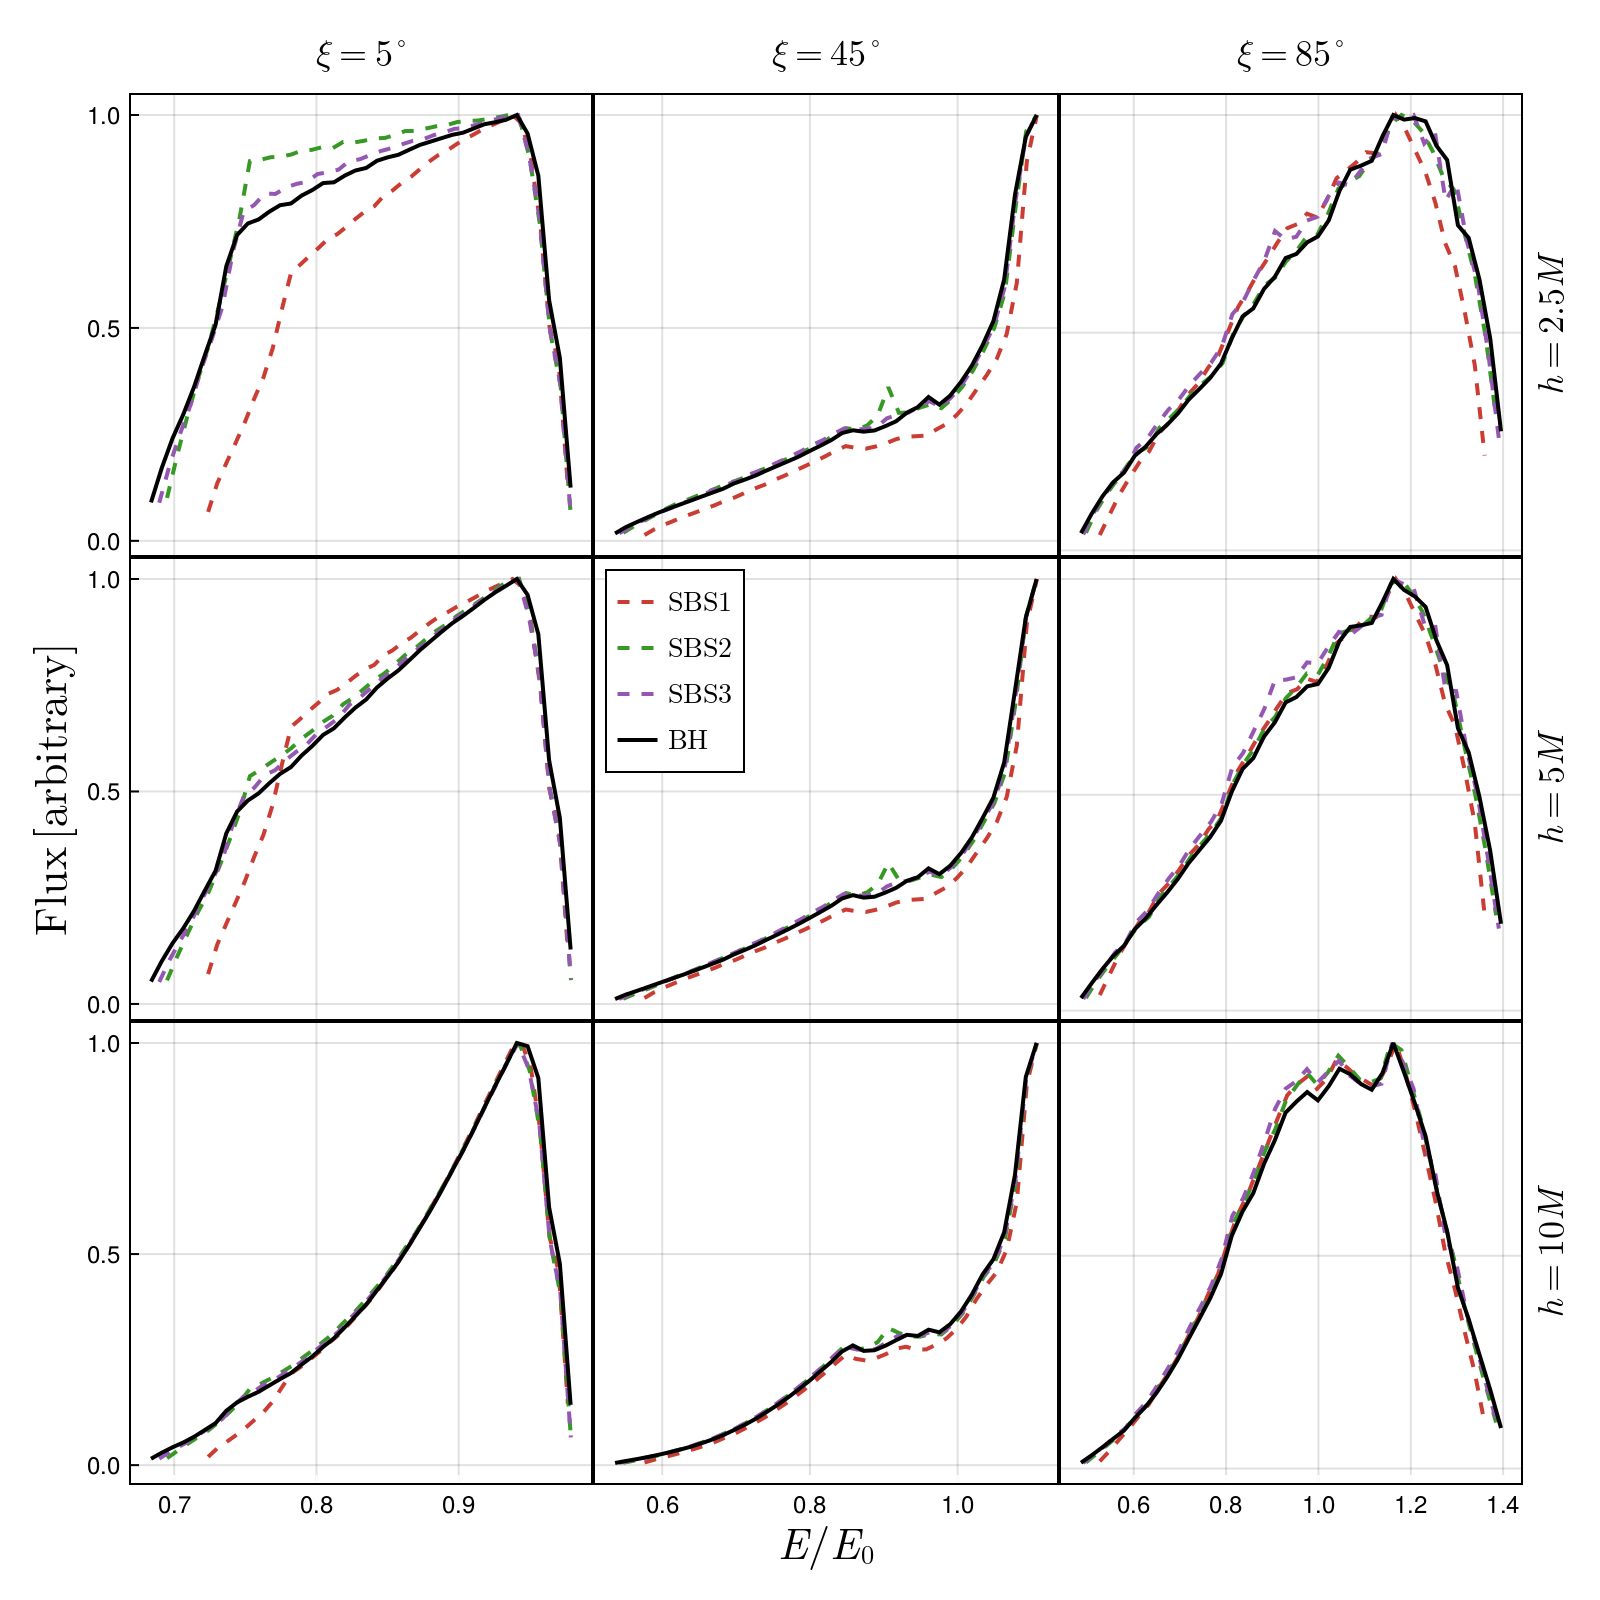

CairoMakie.Screen{PDF}


In [43]:
heights = Any[2.5, 5.0, 10.0]
data_SBS = get_line_data("SBS", heights; num_bins = 40)
data_SCH = get_sch_line_data(heights; num_bins = 40)

axes = Matrix{Axis}(undef, 3, 3)
set_theme!(; fonts = (; regular = "Times New Roman"))
layout = GridLayout(3, 3)
fig = Figure(layout = layout, size=(800,800))
inclination_labels = [L"\xi = 5^\circ", L"\xi = 45^\circ", L"\xi = 85^\circ"]
height_labels = [L"h = 2.5 M", L"h = 5 M", L"h = 10 M"]
model_labelsL = [L"\Lambda \text{BS1}", L"\Lambda \text{BS2}", L"\Lambda \text{BS3}"]
model_labelsS = [L"\text{SBS1}", L"\text{SBS2}", L"\text{SBS3}"]
colors = [julia_red, julia_green, julia_purple]

#i: modelid, j: inclination, k: height
for j in 1:3
    for k in 1:3
        ax = Axis(fig[k,j])
        axes[k,j] = ax
        for i in 1:3
            binned_fluxes_SBS, bins_SBS = data_SBS[i,j,k]
            maxSBS = maximum(binned_fluxes_SBS)
            labelS = L"%$(model_labelsS[i])"#, %$(inclination_labels[j])"
            lines!(ax, midpoints(bins_SBS), binned_fluxes_SBS/maxSBS; linewidth=2.0, color=colors[i], linestyle=:dash, label=labelS)
        end
        binned_fluxes_SCH, bins_SCH = data_SCH[j,k]
        maxSCH = maximum(binned_fluxes_SCH)
        lines!(ax, midpoints(bins_SCH), binned_fluxes_SCH/maxSCH; linewidth=2.0, color=:black, linestyle=:solid, label=L"\text{BH}")
    end
end

for k in 1:3
    axbottom = axes[3,k]
    axtop = axes[1,k]
    axright = axes[k,3]
    axleft = axes[k,1]
    # axbottom.xlabel = L"\alpha \, [\text{rad}]"
    axbottom.xlabel = L"E / E_0"
    axbottom.xlabelvisible = k == 2 #Only show xlabel for middle column
    axbottom.xlabelsize = 22
    axbottom.xticklabelsize = 12
    axbottom.xtickalign = 1
    axbottom.xtickcolor = :white

    axleft.ylabelvisible = k == 2 #Only show ylabel for middle row
    axleft.ylabel = L"\text{Flux} \, [\text{arbitrary}]"
    axleft.ylabelsize = 22
    axleft.yticklabelsize = 12
    axleft.ytickalign = 1

    for l in 1:2
        #Link axes and hide decorations of non-right and non-bottom axes
        #axis linking is redundant here (the ranges coincide already), but just in case
        linkxaxes!(axbottom, axes[l,k])
        hidexdecorations!(axes[l,k], grid=false)
        linkyaxes!(axleft, axes[k,l])
        hideydecorations!(axes[k,l+1], grid=false)
    end

    #Make left ylabel visible again to use as model label
    axright.yaxisposition = :right
    axright.ylabelvisible = true
    axright.ylabel = height_labels[k]
    axright.ylabelsize = 18
    
    supertitle = Label(fig[0,k], inclination_labels[k], justification=:center, fontsize=18, color=:black)
    supertitle.tellwidth = false
    supertitle.padding = (0.0, 0.0, 10.0, 0.0)

end

leg = axislegend(axes[2,2], position=:lt, nbanks = 4, orientation=:horizontal)
colgap!(fig.layout, 1)
rowgap!(fig.layout, 1)
display(fig)
save("plots/linemosaic_new.pdf", fig, pt_per_unit = 0.5)

In [24]:
function myf!(array)
    array=ones(3)
    return nothing
end

A = zeros(3)

myf!(Complex(1.0))

In [25]:
A

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [12]:
a = 1.0

array = zeros(4)

4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0

In [18]:
A = zeros(4)
B = 1.0

A = B

1.0

In [19]:
A = 1.0

1.0

In [ ]:
a = 1.0